Average Rise Time: 0.146209 seconds
Individual Rise Times: [0.1461887359619141, 0.146202802658081, 0.14623403549194336]
Average Fall Time: 0.003642 seconds
Individual Fall Times: [0.0034394264221191, 0.003929376602172907, 0.0035796165466308594, 0.003620624542236439]
1.9709864957656211 2.164499885557336


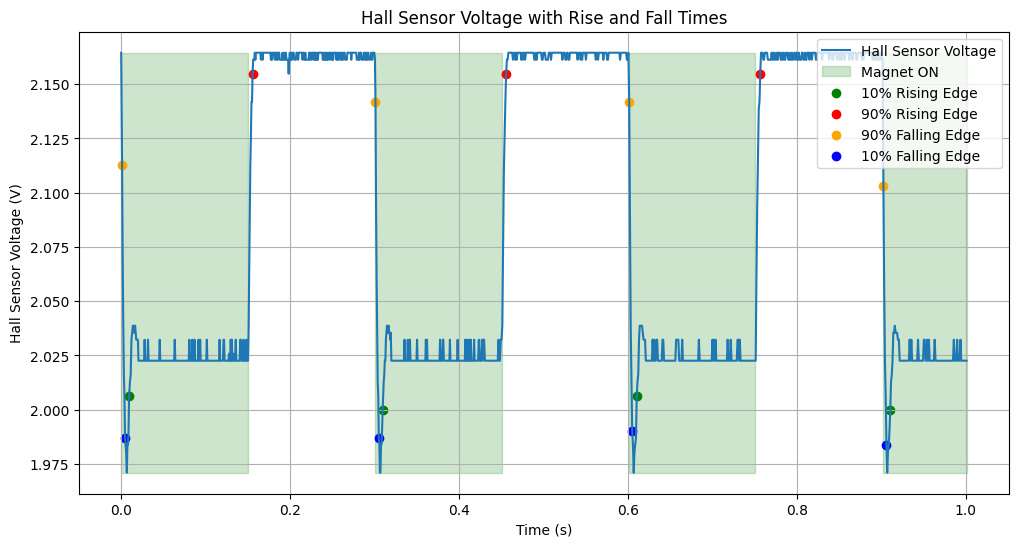

In [16]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

# ---------------------------
#  RISE AND FALL TIME ANALYSIS
# ---------------------------
def calculate_rise_fall_times(data):
    """
    Calculate rise and fall times (10% to 90%) of the voltage transitions.
    
    Args:
    - data: DataFrame containing time and voltage
    
    Returns:
    - A dictionary with lists of rise times and fall times
    """
    curr_time = data["Time (s)"]
    voltage = data["Hall Sensor Voltage (V)"]
    rise_times = []
    fall_times = []

    # Define thresholds for 10% and 90% of steady-state values
    max_voltage = np.max(voltage)
    min_voltage = np.min(voltage)
    threshold_10 = min_voltage + 0.1 * (max_voltage - min_voltage)
    threshold_90 = min_voltage + 0.9 * (max_voltage - min_voltage)

    rising_start = None
    falling_start = None
    
    rising_edges = []
    falling_edges = []

    for i in range(1, len(voltage)):
        # Detect rising transition
        if voltage[i - 1] < threshold_10 and voltage[i] >= threshold_10:
            rising_start = curr_time[i]
            rising_edges.append((curr_time[i], voltage[i]))
        elif voltage[i - 1] < threshold_90 and voltage[i] >= threshold_90 and rising_start is not None:
            rise_times.append(curr_time[i] - rising_start)
            rising_edges.append((curr_time[i], voltage[i]))
            rising_start = None

        # Detect falling transition
        if voltage[i - 1] > threshold_90 and voltage[i] <= threshold_90:
            falling_start = curr_time[i]
            falling_edges.append((curr_time[i], voltage[i]))
        elif voltage[i - 1] > threshold_10 and voltage[i] <= threshold_10 and falling_start is not None:
            fall_times.append(curr_time[i] - falling_start)
            falling_edges.append((curr_time[i], voltage[i]))
            falling_start = None

    return {
        "rise_times": rise_times,
        "fall_times": fall_times,
        "rising_edges": rising_edges,
        "falling_edges": falling_edges
    }

file_name = "switching_speed_multithreaded.csv"
# Load the data into a DataFrame
data = pd.read_csv(file_name)

# Analyze rise and fall times
transition_times = calculate_rise_fall_times(data)
rise_times = transition_times["rise_times"]
fall_times = transition_times["fall_times"]
rising_edges = transition_times["rising_edges"]
falling_edges = transition_times["falling_edges"]

if rise_times:
    avg_rise_time = np.mean(rise_times)
    print(f"Average Rise Time: {avg_rise_time:.6f} seconds")
    print(f"Individual Rise Times: {rise_times}")
else:
    print("No rise transitions detected in the data.")

if fall_times:
    avg_fall_time = np.mean(fall_times)
    print(f"Average Fall Time: {avg_fall_time:.6f} seconds")
    print(f"Individual Fall Times: {fall_times}")
else:
    print("No fall transitions detected in the data.")

# ---------------------------
# PLOTTING
# ---------------------------


# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(data["Time (s)"], data["Hall Sensor Voltage (V)"], label="Hall Sensor Voltage")

v_min = data["Hall Sensor Voltage (V)"].min()
v_max = data["Hall Sensor Voltage (V)"].max()
print(v_min, v_max)

# Highlight magnet ON/OFF periods
plt.fill_between(data["Time (s)"],
                 v_min, v_max,  # Fill between v_min and v_max vertically
                 where=data["Magnet State"] == 1,
                 color='green', alpha=0.2, label="Magnet ON")  # No need for transform here

# Highlight rising and falling edges
rising_x, rising_y = zip(*rising_edges)
falling_x, falling_y = zip(*falling_edges)

plt.scatter(rising_x[::2], rising_y[::2], color='green', label='10% Rising Edge')
plt.scatter(rising_x[1::2], rising_y[1::2], color='red', label='90% Rising Edge')
plt.scatter(falling_x[::2], falling_y[::2], color='orange', label='90% Falling Edge')
plt.scatter(falling_x[1::2], falling_y[1::2], color='blue', label='10% Falling Edge')

# Add labels and title
plt.xlabel("Time (s)")
plt.ylabel("Hall Sensor Voltage (V)")
plt.title("Hall Sensor Voltage with Rise and Fall Times")
plt.legend(loc="upper right")
plt.grid(True)

# Show the plot
plt.show()